# Visualisation of Annotated Frames

In [1]:
def load_yolo_labels(label_path):
    """
    Load YOLO format labels from the given path.

    Parameters:
    label_path: str
        Path to the label file.

    Returns:
    list of tuples
        List of bounding boxes (class_id, center_x, center_y, width, height).
    """
    with open(label_path, 'r') as file:
        labels = []
        for line in file:
            class_id, center_x, center_y, width, height = map(float, line.strip().split())
            labels.append((int(class_id), center_x, center_y, width, height))
        return labels

In [2]:
from PIL import Image
import cv2
import numpy as np

def annotate_image(img, yolo_bbox):
    """
    Annotate the image with the bounding boxes of the detected objects.

    Parameters:
    img: PIL.Image
        The image to annotate.
    yolo_bbox: list of tuples
        List of YOLO format bounding boxes (class_id, center_x, center_y, width, height).

    Returns:
    PIL.Image
        The annotated image.
    """
    img = np.array(img)
    height, width, _ = img.shape
    
    for bbox in yolo_bbox:
        class_id, center_x, center_y, bbox_width, bbox_height = bbox
        
        # Convert YOLO format to corner coordinates
        x1 = int((center_x - bbox_width / 2) * width)
        y1 = int((center_y - bbox_height / 2) * height)
        x2 = int((center_x + bbox_width / 2) * width)
        y2 = int((center_y + bbox_height / 2) * height)
        
        # Draw rectangle around detected object
        color = (0, 255, 0)  # Green color for bounding box
        thickness = 2  # Thickness of bounding box lines
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        
        # Optionally, add the class ID or label
        if class_id == 0: 
            state = "[CLOSED]"
        elif class_id == 1: 
            state = "[SEMI-OPEN]"
        elif class_id == 2: 
            state = "[OPEN]"
        else:
            return Image.fromarray(img)
        label = f"Refuelling Port {state}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
        cv2.rectangle(img, (label_x, label_y - label_size[1]), 
                      (label_x + label_size[0], label_y + label_size[1]), color, -1)
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return Image.fromarray(img)


In [14]:
import random
import os
from PIL import Image

from torchvision.utils import make_grid, save_image
import torchvision.transforms.functional as TF

folder_path = "../../data/AARP/frames/full_dataset_annotated_YOLO/all"
grid_size = 3

images_folder_path = folder_path + "/images"
labels_folder_path = folder_path + "/labels"

images = []
for i in range(grid_size * grid_size):
    image_file = random.choice(os.listdir(images_folder_path))
    image_path = os.path.join(images_folder_path, image_file)
    label_path = os.path.join(labels_folder_path, os.path.splitext(image_file)[0] + '.txt')
    
    image = Image.open(image_path)

    # Resize the image to 256x256
    image = image.resize((256, 256))

    labels = load_yolo_labels(label_path)
    annotated_image = annotate_image(image, labels)
    
    # Transform the annotated image to tensor
    image_tensor = TF.to_tensor(annotated_image)
    images.append(image_tensor)

# Create a grid of images
grid_image = make_grid(images, nrow=grid_size)
save_image(grid_image, "AGRDatasetGrid.png")


# Visualisation of Refuelling Port Trajectory

In [1]:
import json

def load_json(path: str) -> dict:
    """
    Load a JSON file and return its contents as a dictionary.

    Args:
        path (str): The file path to the JSON file.

    Returns:
        dict: The contents of the JSON file as a dictionary.
    """
    with open(path, "r") as file:
        return json.load(file)

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

test_data_path = "../../data/AARP/frames/full_dataset_annotated_fpp/test.json"
test_filtered_ema_path = "../../data/AARP/frames/full_dataset_annotated_fpp/test_filter_ema.json"
test_filtered_rolling_mean_path = "../../data/AARP/frames/full_dataset_annotated_fpp/test_filter_rolling_mean.json"
test_filtered_gaussian_path = "../../data/AARP/frames/full_dataset_annotated_fpp/test_filter_gaussian.json"
test_filtered_savgol_path = "../../data/AARP/frames/full_dataset_annotated_fpp/test_filter_savgol.json"

# Load the JSON data
raw_data = load_json(test_data_path)
data_filtered_ema = load_json(test_filtered_ema_path)
data_filtered_gaussian = load_json(test_filtered_gaussian_path)
data_filtered_rolling_mean = load_json(test_filtered_rolling_mean_path)
data_filtered_savgol = load_json(test_filtered_savgol_path)

# Select a random video ID
video_ids = list(set(entry['video_id'] for entry in raw_data))

In [18]:
video_id = video_ids[1]

In [19]:
import numpy as np

def return_video_data(data, video_id) -> tuple:
    """
    Extract bounding box data, velocities, and accelerations for a specific video.

    Args:
        data (list): A list of dictionaries where each dictionary contains video data,
                     including "video_id" and "frames".
        video_id (str): The ID of the video for which to extract data.

    Returns:
        tuple: A tuple containing the following elements:
            - frame_ids (tuple): A tuple of frame IDs sorted by frame order.
            - bbox_array (numpy.ndarray): A 2D array of bounding boxes for each frame.
            - velocities (numpy.ndarray): A 2D array of velocities calculated between consecutive frames.
            - accelerations (numpy.ndarray): A 2D array of accelerations calculated between consecutive frames.
    """
    selected_bbox_data = []
    for entry in data:
        if entry["video_id"] == video_id:
            for frame in entry["frames"]:
                bbox = frame["bbox"]
                bbox = [0 if coord is None else coord for coord in bbox]
                selected_bbox_data.append((frame["frame_id"], bbox))

    # Sort the data by frame_id
    selected_bbox_data = sorted(selected_bbox_data, key=lambda x: x[0])

    # Convert to numpy array for easier manipulation
    frame_ids, bboxes = zip(*selected_bbox_data)
    bbox_array = np.array(bboxes)

    # Calculate velocity and acceleration
    velocities = np.diff(bbox_array, axis=0)
    accelerations = np.diff(velocities, axis=0)

    # Insert zeros for the first frame's velocity and acceleration
    velocities = np.vstack(([0, 0, 0, 0], velocities))
    accelerations = np.vstack(([0, 0, 0, 0], [0, 0, 0, 0], accelerations))

    return (frame_ids, bbox_array, velocities, accelerations)

In [20]:
raw_data_frame_ids, raw_data_bboxes, raw_data_velocities, raw_data_accelerations = return_video_data(raw_data, video_id)
data_filtered_ema_frame_ids, data_filtered_ema_bboxes, data_filtered_ema_velocities, data_filtered_ema_accelerations = return_video_data(data_filtered_ema, video_id)
data_filtered_rolling_mean_frame_ids, data_filtered_rolling_mean_bboxes, data_filtered_rolling_mean_velocities, data_filtered_rolling_mean_accelerations = return_video_data(data_filtered_rolling_mean, video_id)
data_filtered_gaussian_frame_ids, data_filtered_gaussian_bboxes, data_filtered_gaussian_velocities, data_filtered_gaussian_accelerations = return_video_data(data_filtered_gaussian, video_id)
data_filtered_savgol_frame_ids, data_filtered_savgol_bboxes, data_filtered_savgol_velocities, data_filtered_savgol_accelerations = return_video_data(data_filtered_savgol, video_id)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_central_position(video_id, frame_indices, x_center, y_center, folder_save_path):
    """
    Plot the central position of the bounding box over time.

    Args:
        video_id (str): The ID of the video being analyzed.
        frame_indices (numpy.ndarray): Array of frame indices.
        x_center (numpy.ndarray): Array of x-coordinates of the bounding box center.
        y_center (numpy.ndarray): Array of y-coordinates of the bounding box center.
        folder_save_path (str): Directory path to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, x_center, label="X Center")
    plt.plot(frame_indices, y_center, label="Y Center")
    
    # Increase font size
    plt.rcParams.update({'font.size': 18})
    plt.rcParams.update({'legend.fontsize': 18})
    
    plt.xlabel("Frame", fontsize=18)
    plt.ylabel("Normalised Coordinate", fontsize=18)
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_central_position.png")
    plt.savefig(save_path)

    plt.show()

def plot_velocity(video_id, frame_indices, x_velocity, y_velocity, folder_save_path):
    """
    Plot the velocity of the bounding box over time.

    Args:
        video_id (str): The ID of the video being analyzed.
        frame_indices (numpy.ndarray): Array of frame indices.
        x_velocity (numpy.ndarray): Array of x-axis velocities of the bounding box.
        y_velocity (numpy.ndarray): Array of y-axis velocities of the bounding box.
        folder_save_path (str): Directory path to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, x_velocity, label="X Velocity", color="red")
    plt.plot(frame_indices, y_velocity, label="Y Velocity", color="green")
    
    # Increase font size for better readability
    plt.rcParams.update({'font.size': 18})
    plt.rcParams.update({'legend.fontsize': 18})
    
    plt.xlabel("Frame", fontsize=18)
    plt.ylabel("Velocity", fontsize=18)
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_velocity.png")
    plt.savefig(save_path)

    plt.show()

def plot_acceleration(video_id, frame_indices, x_acceleration, y_acceleration, folder_save_path):
    """
    Plot the acceleration of the bounding box over time.

    Args:
        video_id (str): The ID of the video being analyzed.
        frame_indices (numpy.ndarray): Array of frame indices.
        x_acceleration (numpy.ndarray): Array of x-axis accelerations of the bounding box.
        y_acceleration (numpy.ndarray): Array of y-axis accelerations of the bounding box.
        folder_save_path (str): Directory path to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, x_acceleration, label="X Acceleration", color="red")
    plt.plot(frame_indices, y_acceleration, label="Y Acceleration", color="green")
    
    # Increase font size
    plt.rcParams.update({'font.size': 18})
    plt.rcParams.update({'legend.fontsize': 18})
    
    plt.xlabel("Frame", fontsize=18)
    plt.ylabel("Acceleration", fontsize=18)
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_acceleration.png")
    plt.savefig(save_path)

    plt.show()

def plot_area(video_id, frame_indices, area, folder_save_path):
    """
    Plot the area of the bounding box over time.

    Args:
        video_id (str): The ID of the video being analyzed.
        frame_indices (numpy.ndarray): Array of frame indices.
        area (numpy.ndarray): Array of bounding box areas.
        folder_save_path (str): Directory path to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, area, label="Area", color="green")
    
    # Increase font size
    plt.rcParams.update({'font.size': 18})
    plt.rcParams.update({'legend.fontsize': 18})
    
    plt.xlabel("Frame", fontsize=18)
    plt.ylabel("Area", fontsize=18)
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_area.png")
    plt.savefig(save_path)

    plt.show()

def plot_aspect_ratio(video_id, frame_indices, aspect_ratio, folder_save_path):
    """
    Plot the aspect ratio of the bounding box over time.

    Args:
        video_id (str): The ID of the video being analyzed.
        frame_indices (numpy.ndarray): Array of frame indices.
        aspect_ratio (numpy.ndarray): Array of bounding box aspect ratios.
        folder_save_path (str): Directory path to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, aspect_ratio, label="Aspect Ratio", color="red")
    
    # Increase font size
    plt.rcParams.update({'font.size': 18})
    plt.rcParams.update({'legend.fontsize': 18})
    
    plt.xlabel("Frame", fontsize=18)
    plt.ylabel("Aspect Ratio", fontsize=18)
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_aspect_ratio.png")
    plt.savefig(save_path)

    plt.show()

def plot_bounding_box_metrics(video_id, bbox_array, folder_save_path="/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/report/figures/bbox_metrics"):
    """
    Plot various bounding box metrics (central position, velocity, acceleration, area, aspect ratio).

    Args:
        video_id (str): The ID of the video being analyzed.
        bbox_array (numpy.ndarray): Array of bounding box coordinates with shape (n_frames, 4).
        folder_save_path (str, optional): Directory path to save the plots. Defaults to the provided path.
    """
    # Calculate central position, area, and aspect ratio
    x_center = bbox_array[:, 0] + 0.5 * bbox_array[:, 2]
    y_center = bbox_array[:, 1] + 0.5 * bbox_array[:, 3]
    area = bbox_array[:, 2] * bbox_array[:, 3]
    aspect_ratio = bbox_array[:, 2] / bbox_array[:, 3]

    # Time or frame indices
    frame_indices = np.arange(len(bbox_array))

    # Calculate velocity
    x_velocity = np.diff(x_center, prepend=x_center[0])
    y_velocity = np.diff(y_center, prepend=y_center[0])
    velocity_magnitude = np.sqrt(x_velocity**2 + y_velocity**2)

    # Calculate acceleration
    x_acceleration = np.diff(x_velocity, prepend=x_velocity[0])
    y_acceleration = np.diff(y_velocity, prepend=y_velocity[0])
    acceleration_magnitude = np.sqrt(x_acceleration**2 + y_acceleration**2)

    # Plot each metric in a separate figure
    plot_central_position(video_id, frame_indices, x_center, y_center, folder_save_path)
    plot_velocity(video_id, frame_indices, x_velocity, y_velocity, folder_save_path)
    plot_acceleration(video_id, frame_indices, x_acceleration, y_acceleration, folder_save_path)
    plot_area(video_id, frame_indices, area, folder_save_path)
    plot_aspect_ratio(video_id, frame_indices, aspect_ratio, folder_save_path)

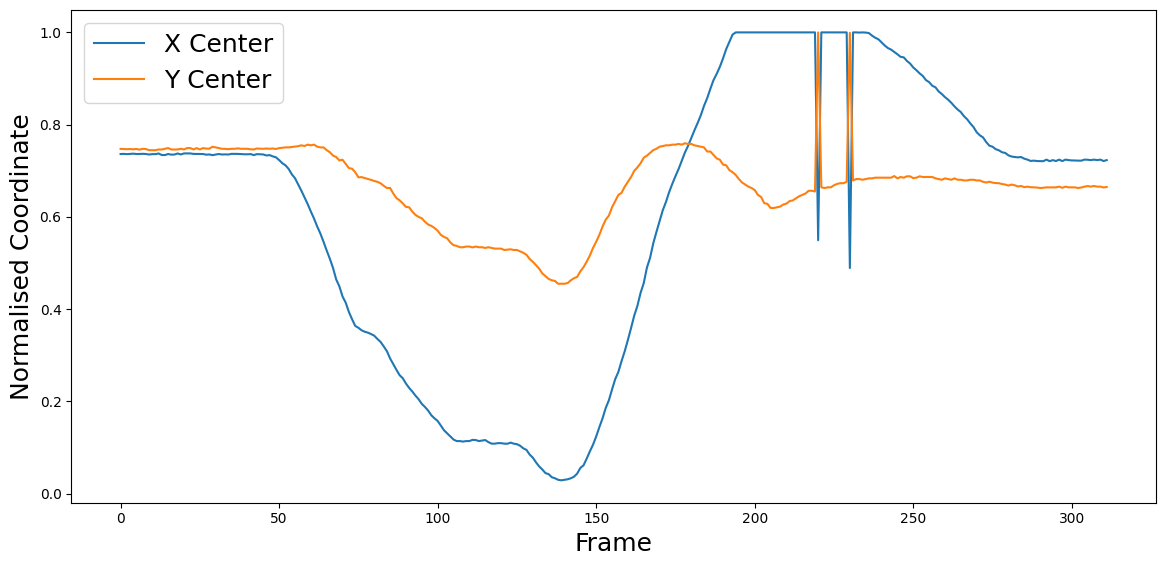

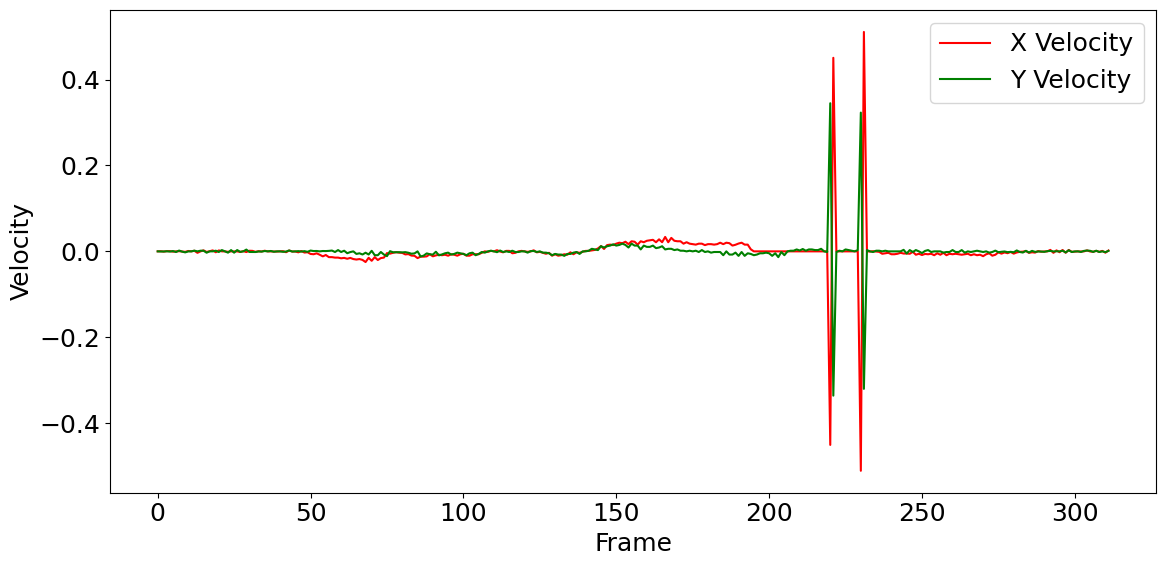

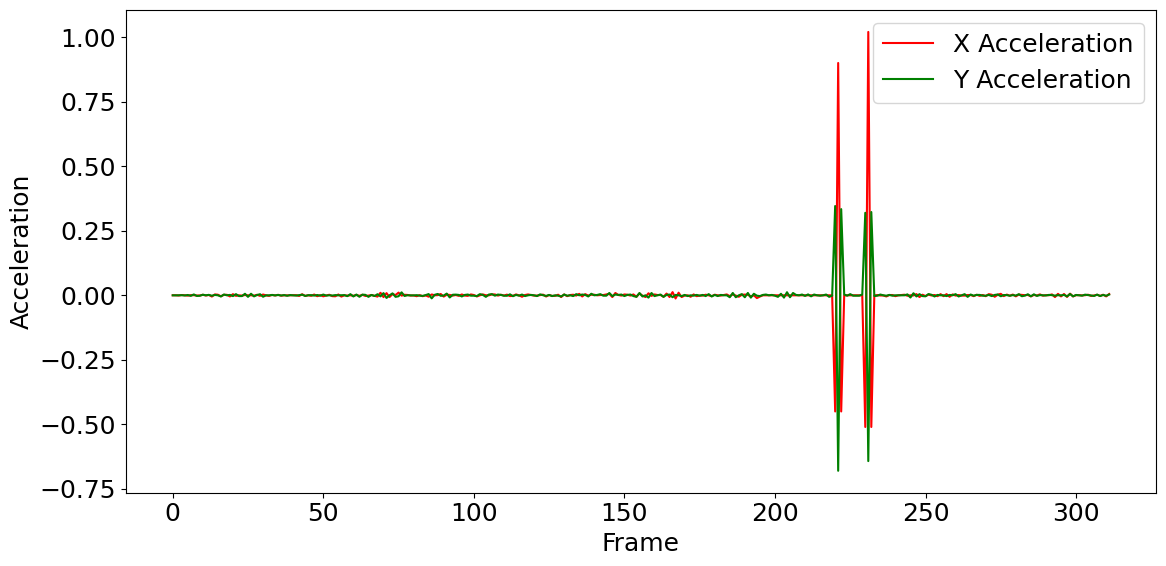

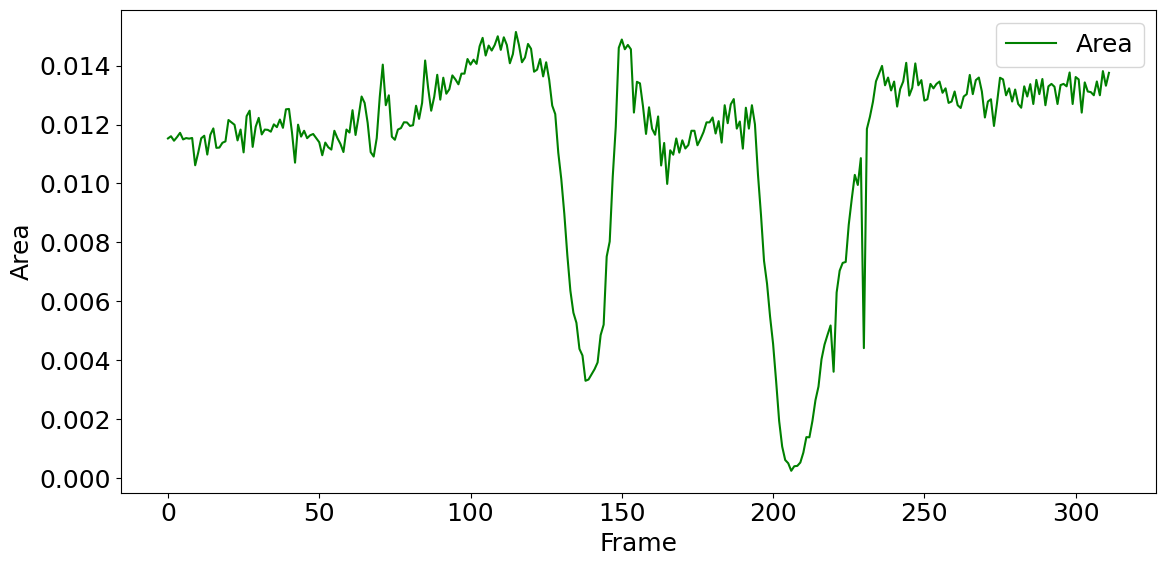

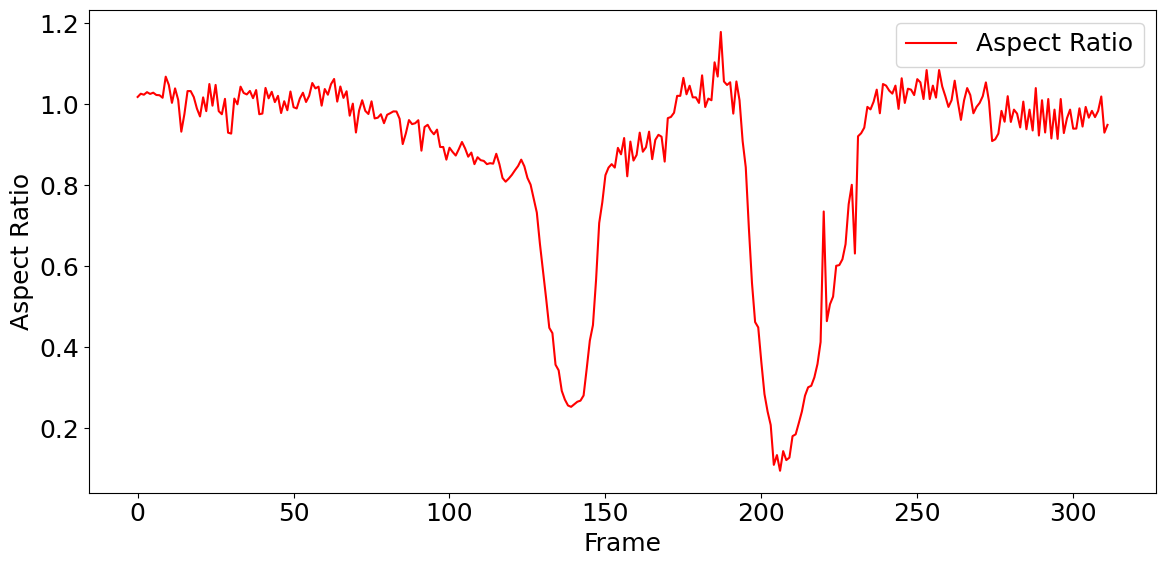

In [22]:
video_id_modified = video_id + " (Raw Data)"
plot_bounding_box_metrics(video_id_modified, raw_data_bboxes)

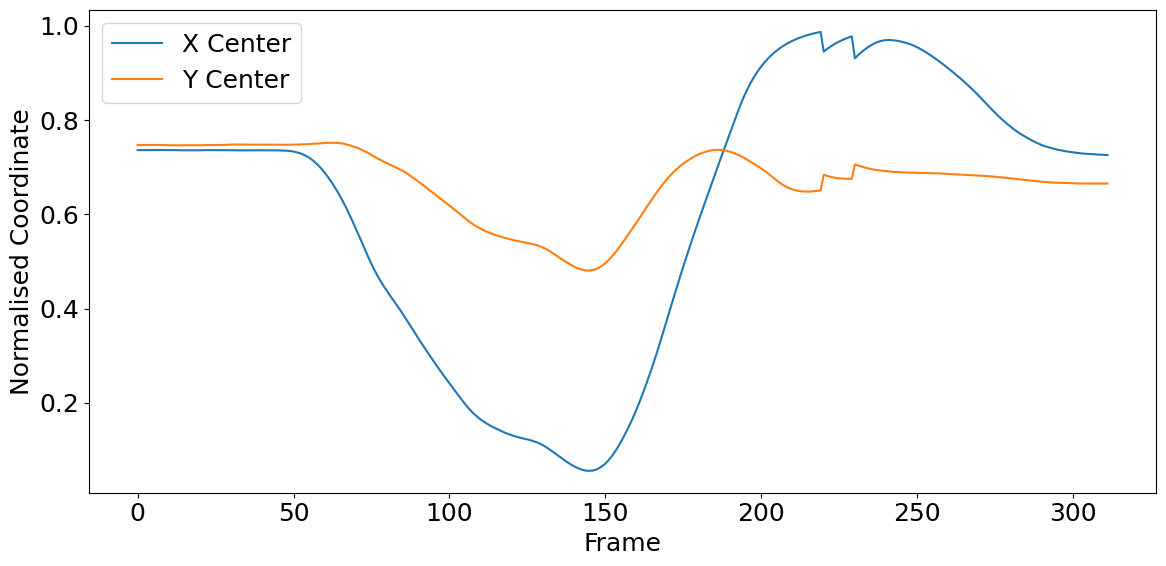

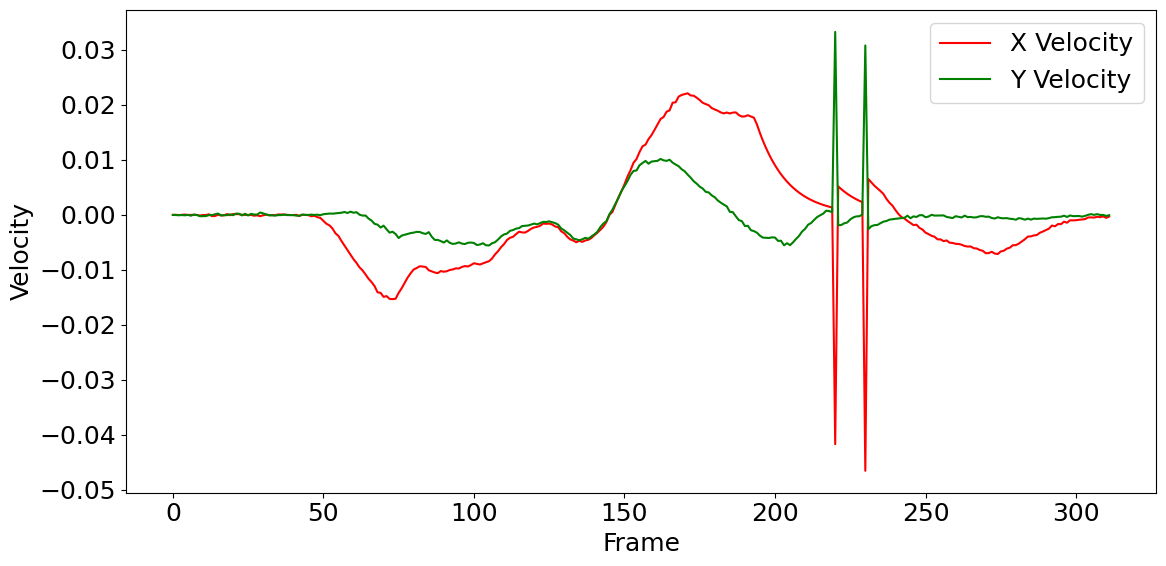

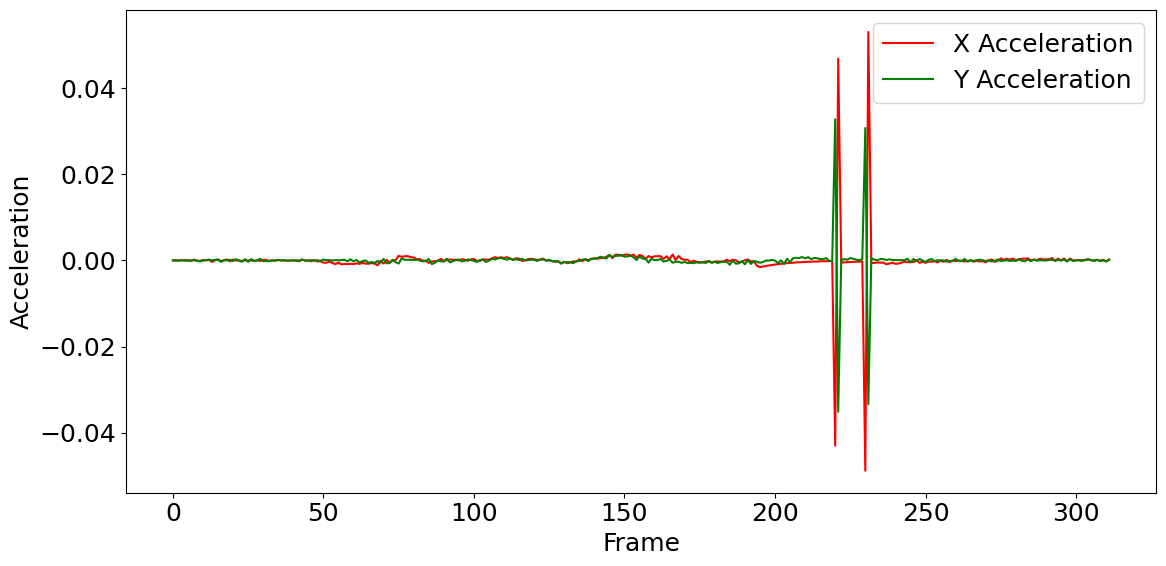

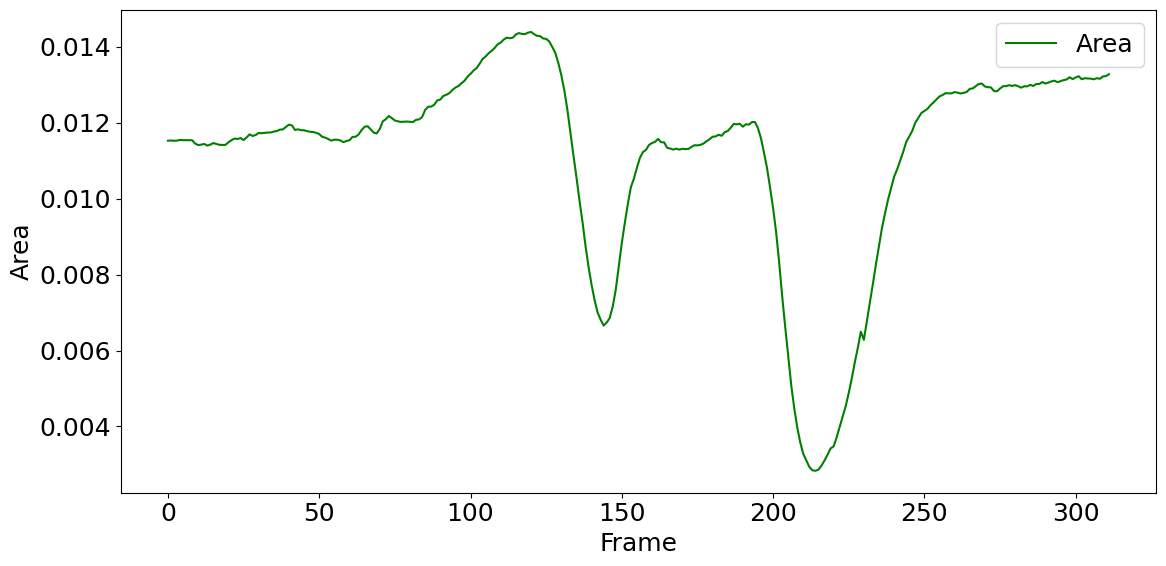

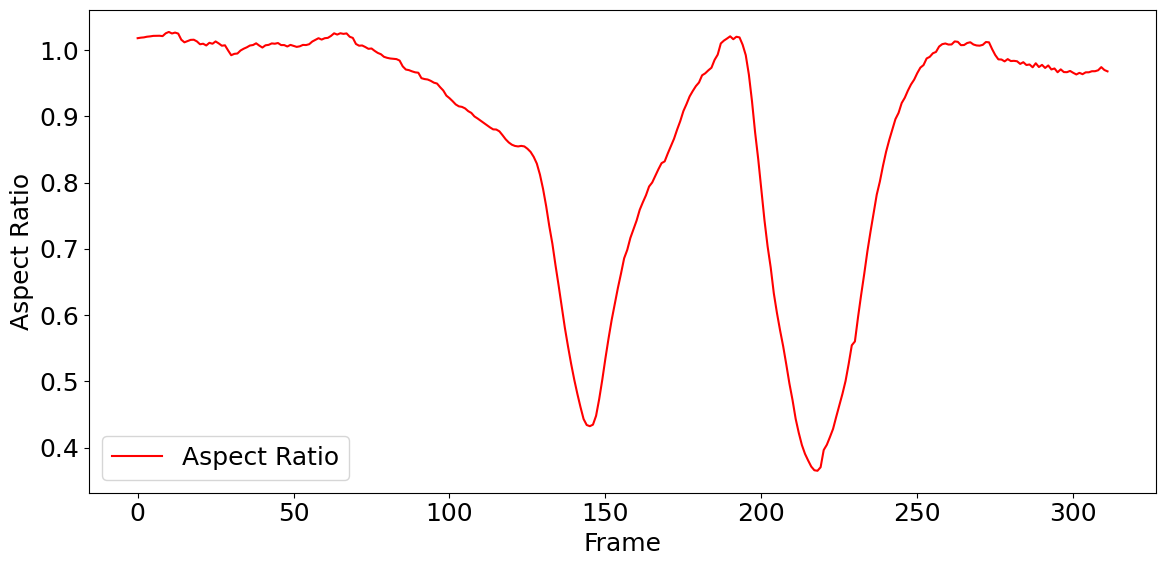

In [65]:
modified_video_id = video_id + " (EMA Filter)"
plot_bounding_box_metrics(modified_video_id, data_filtered_ema_bboxes)  # EMA Filter

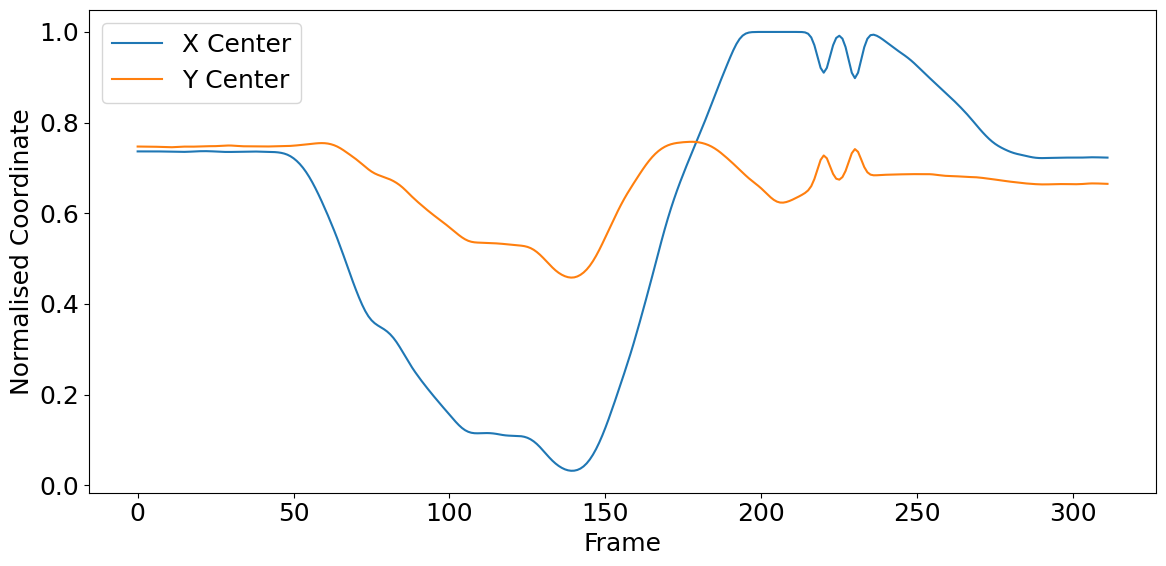

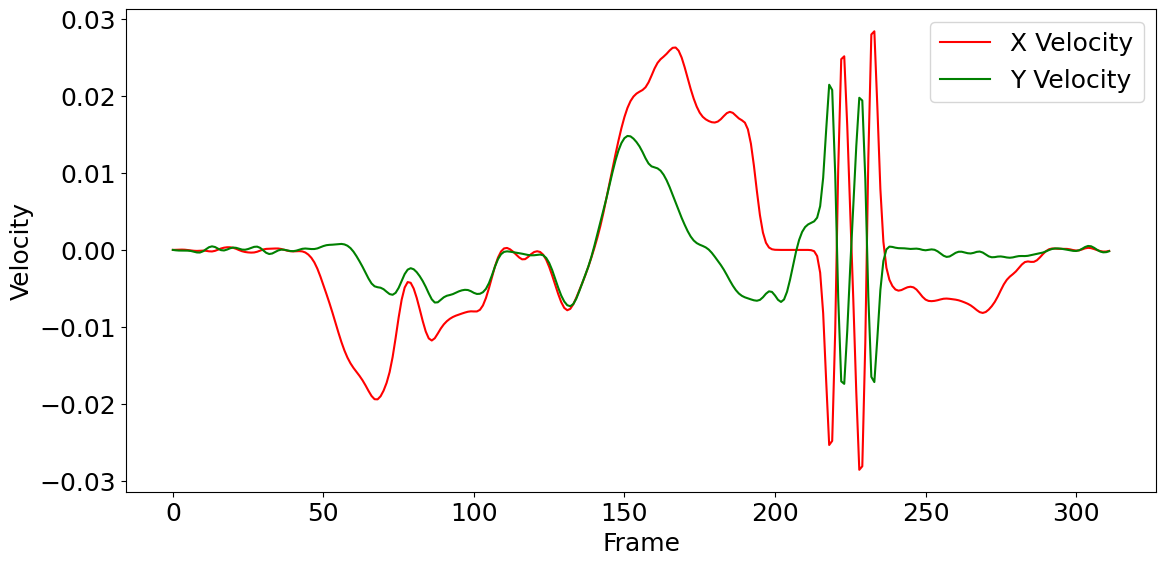

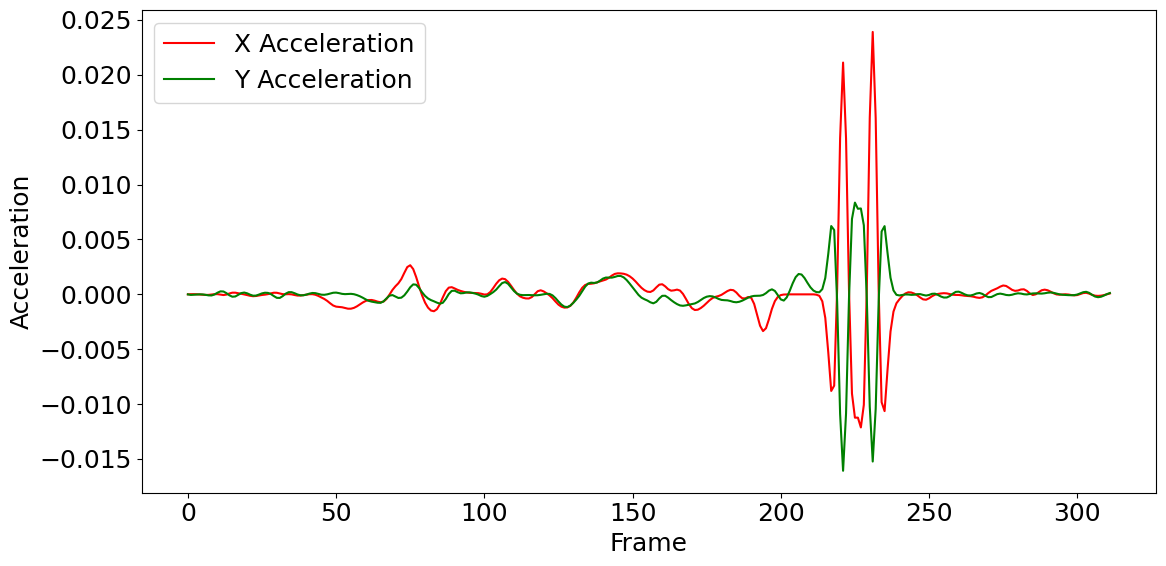

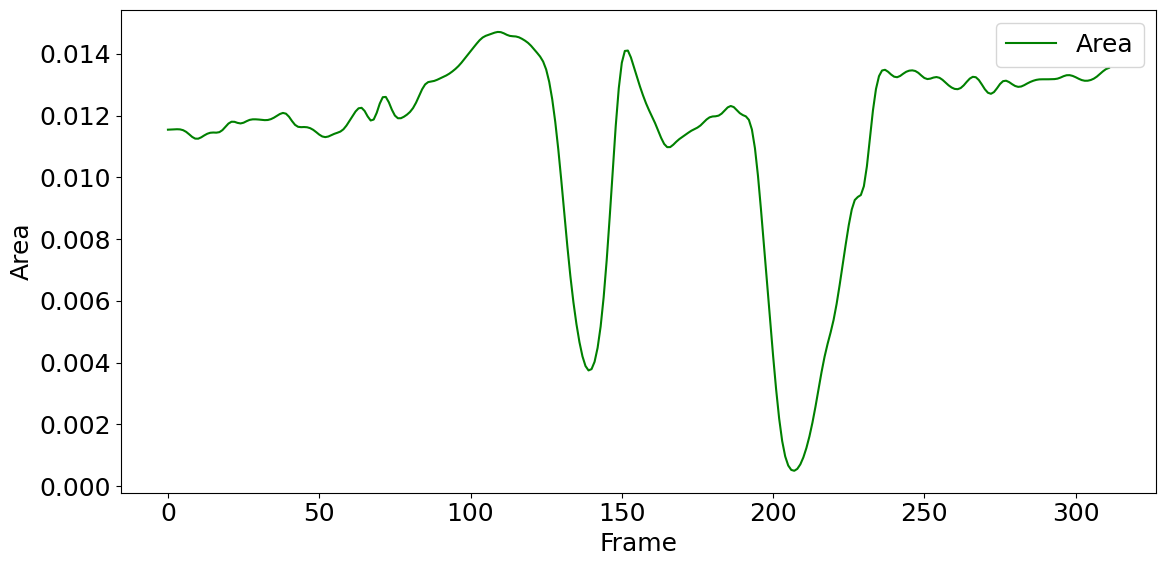

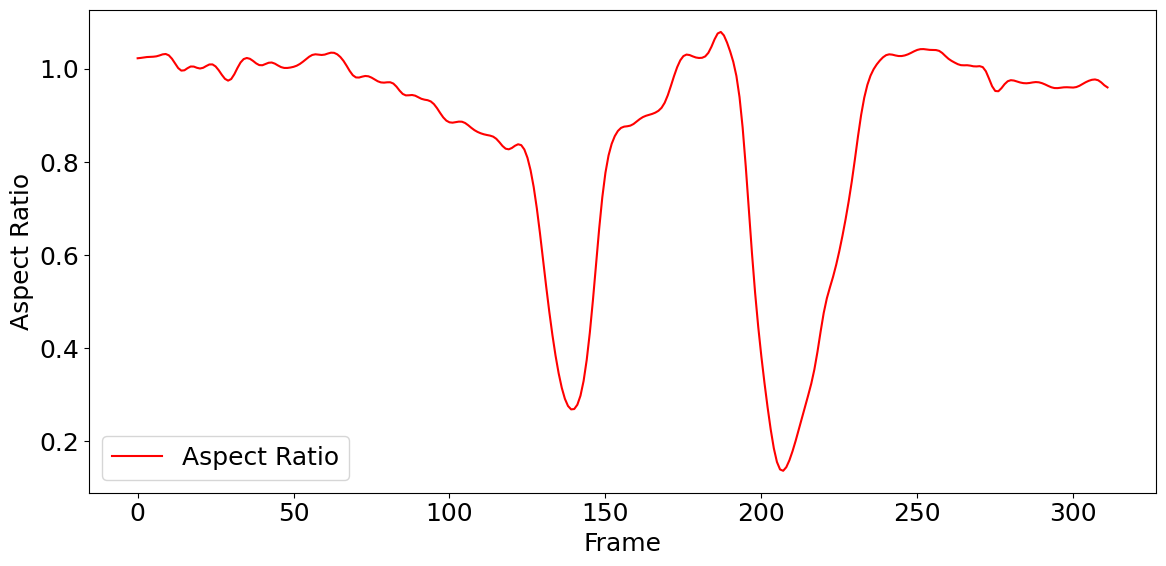

In [23]:
modified_video_id = video_id + " (Gaussian Filter)"
plot_bounding_box_metrics(modified_video_id, data_filtered_gaussian_bboxes)  # Gaussian Filter

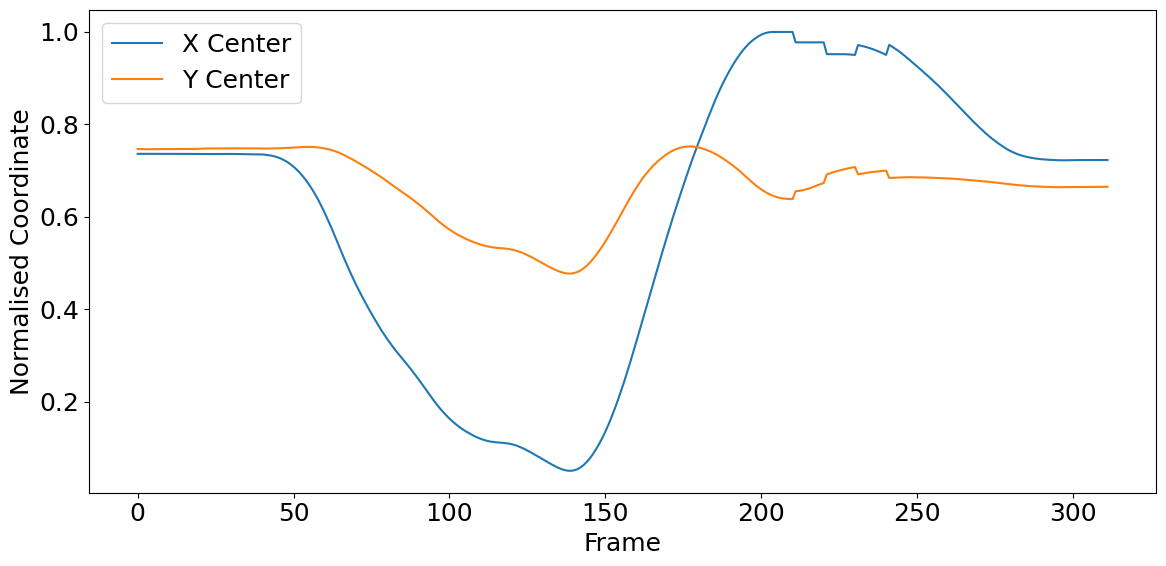

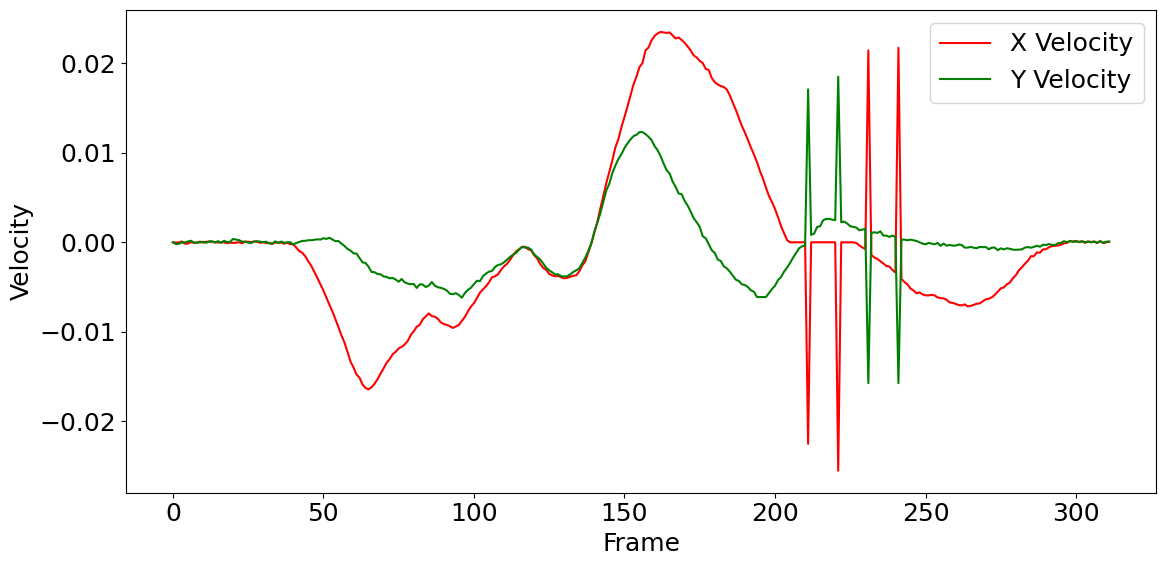

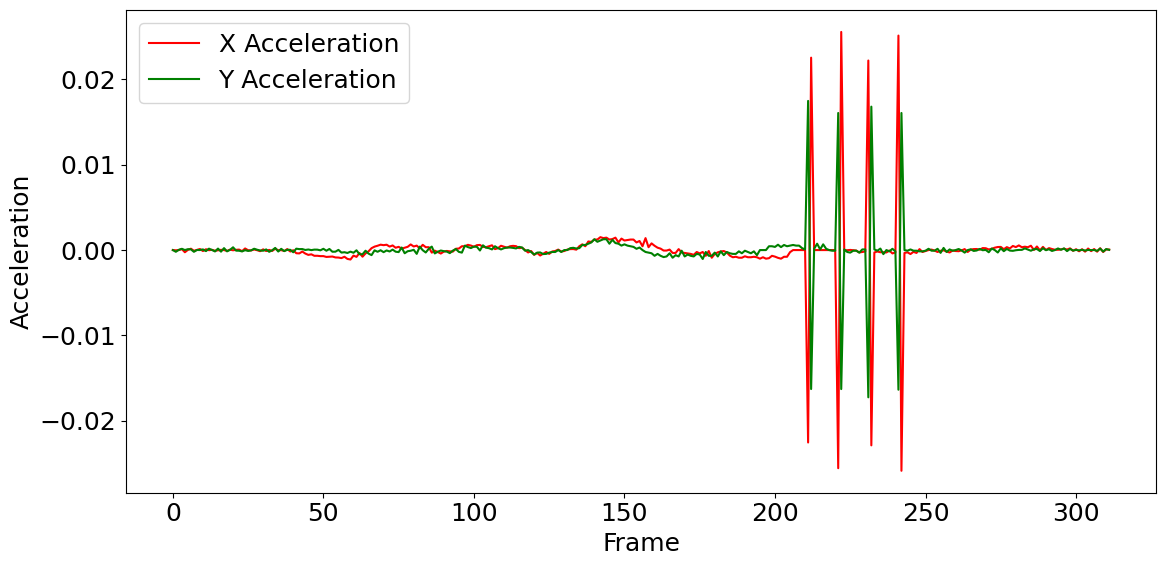

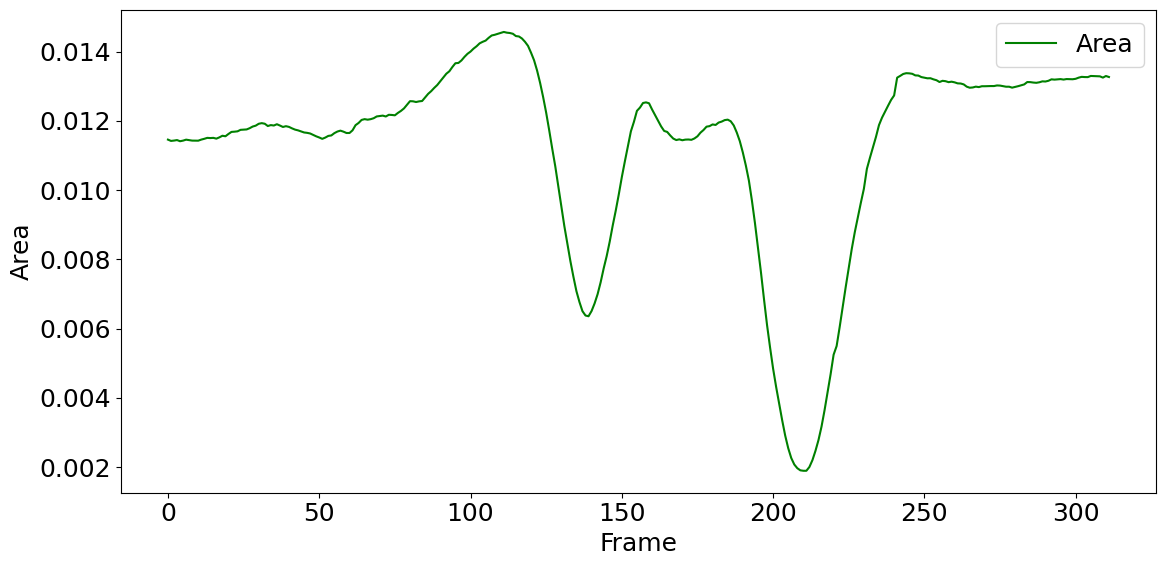

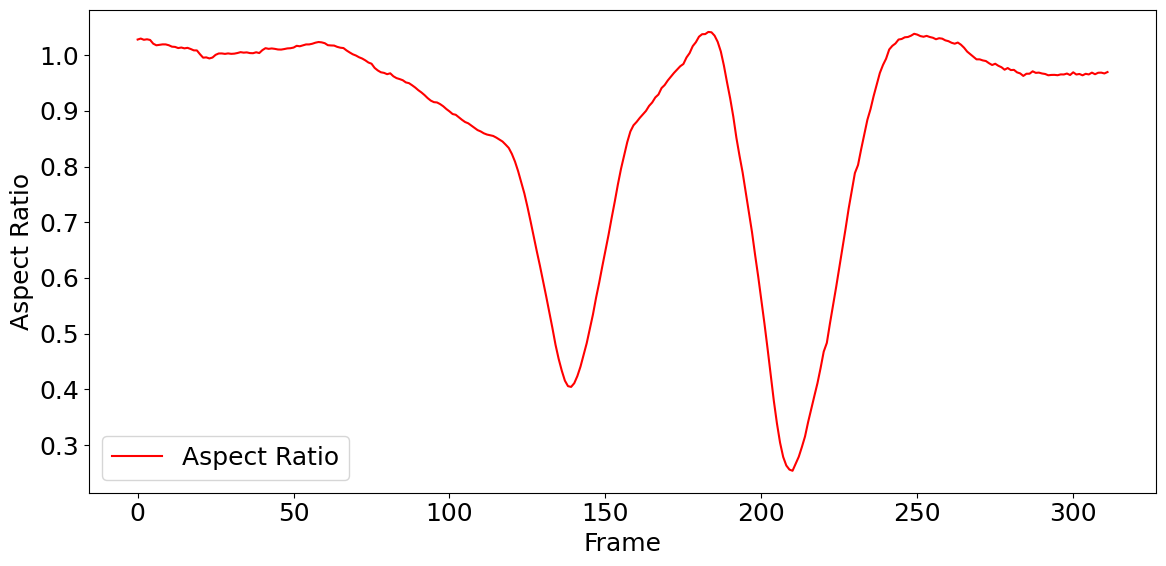

In [24]:
modified_video_id = video_id + " (Rolling Mean Filter)"
plot_bounding_box_metrics(modified_video_id, data_filtered_rolling_mean_bboxes)  # Rolling Mean Filter

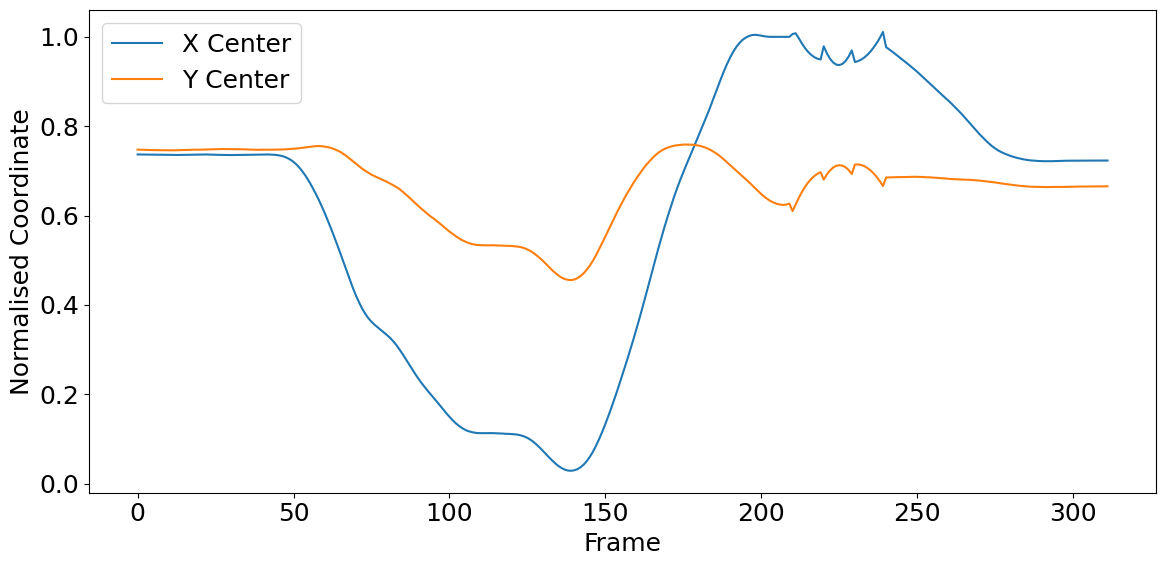

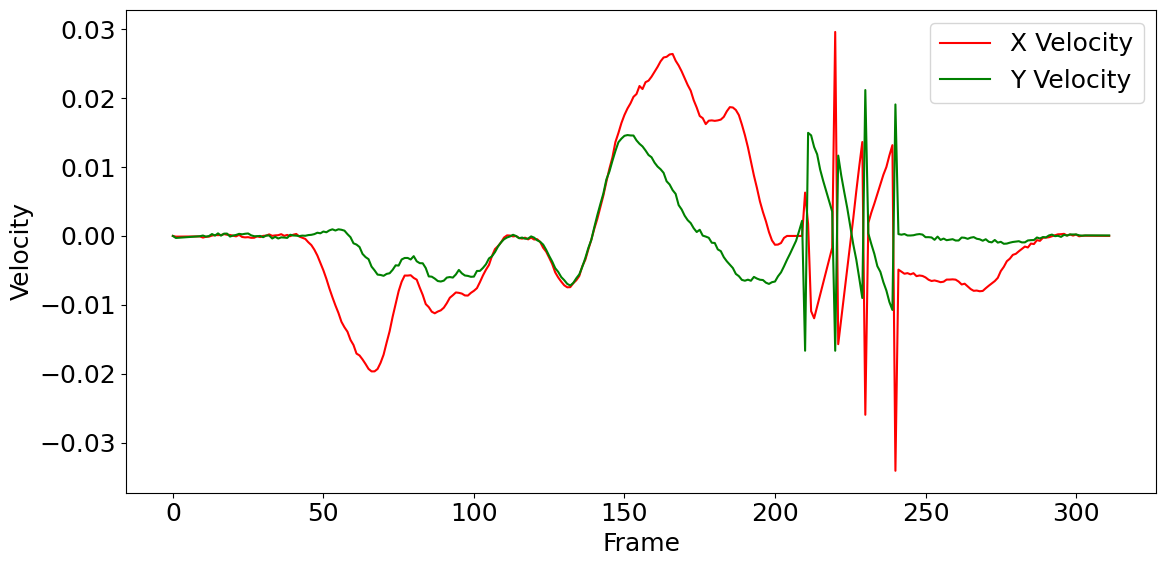

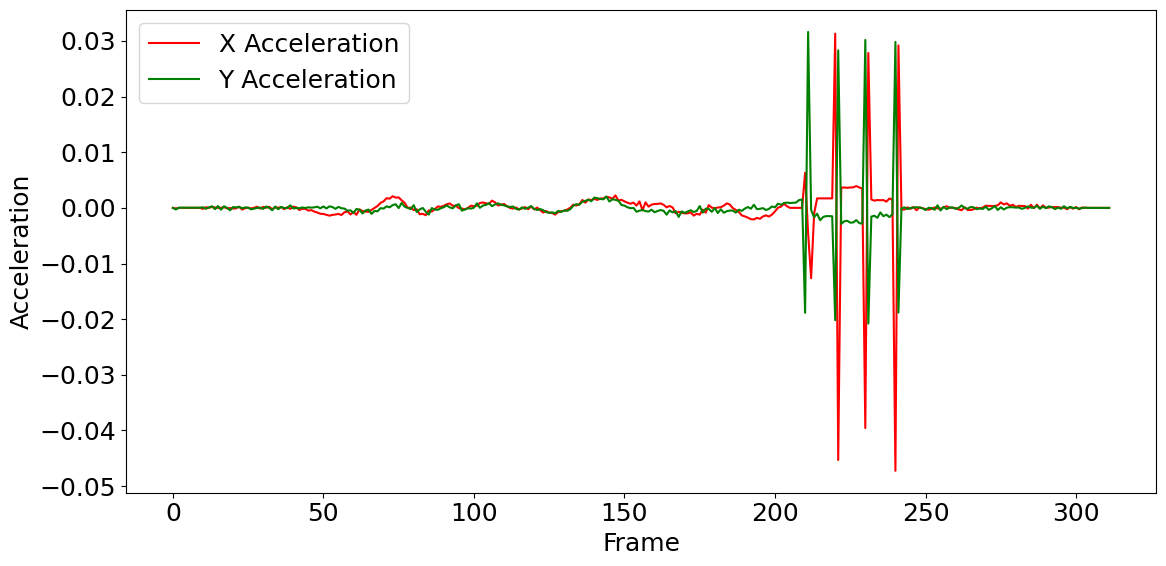

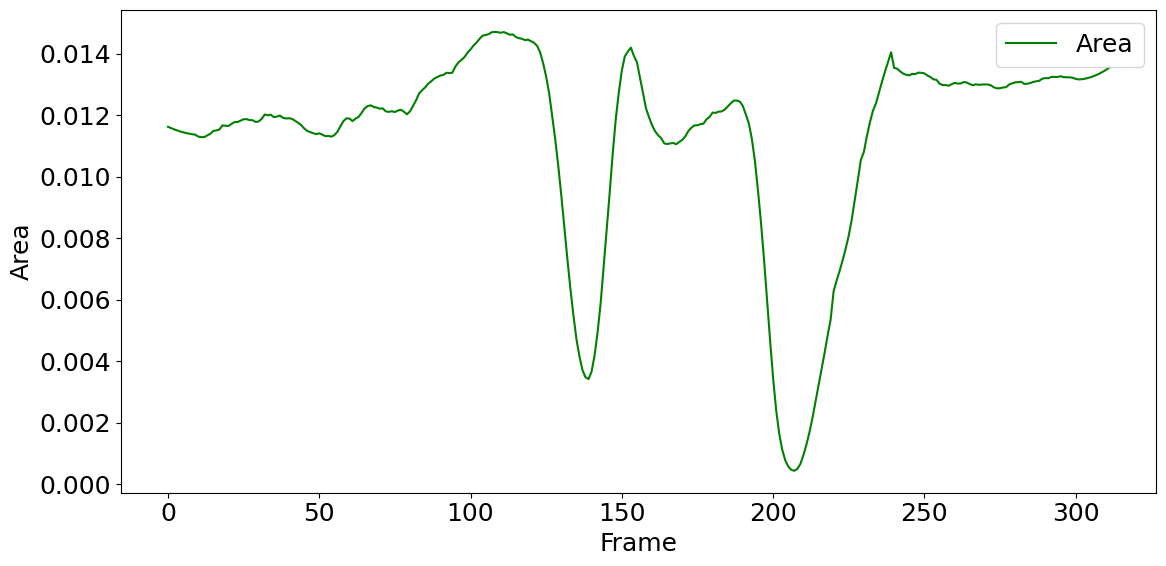

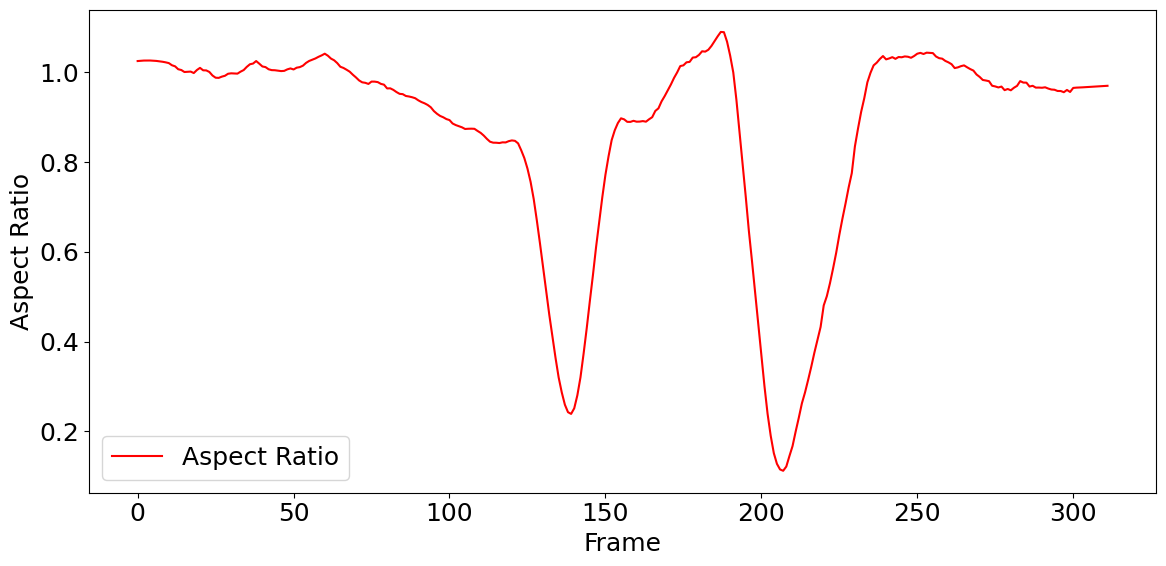

In [25]:
modified_video_id = video_id + " (Savgol Filter)"
plot_bounding_box_metrics(modified_video_id, data_filtered_savgol_bboxes)

# Framework Results

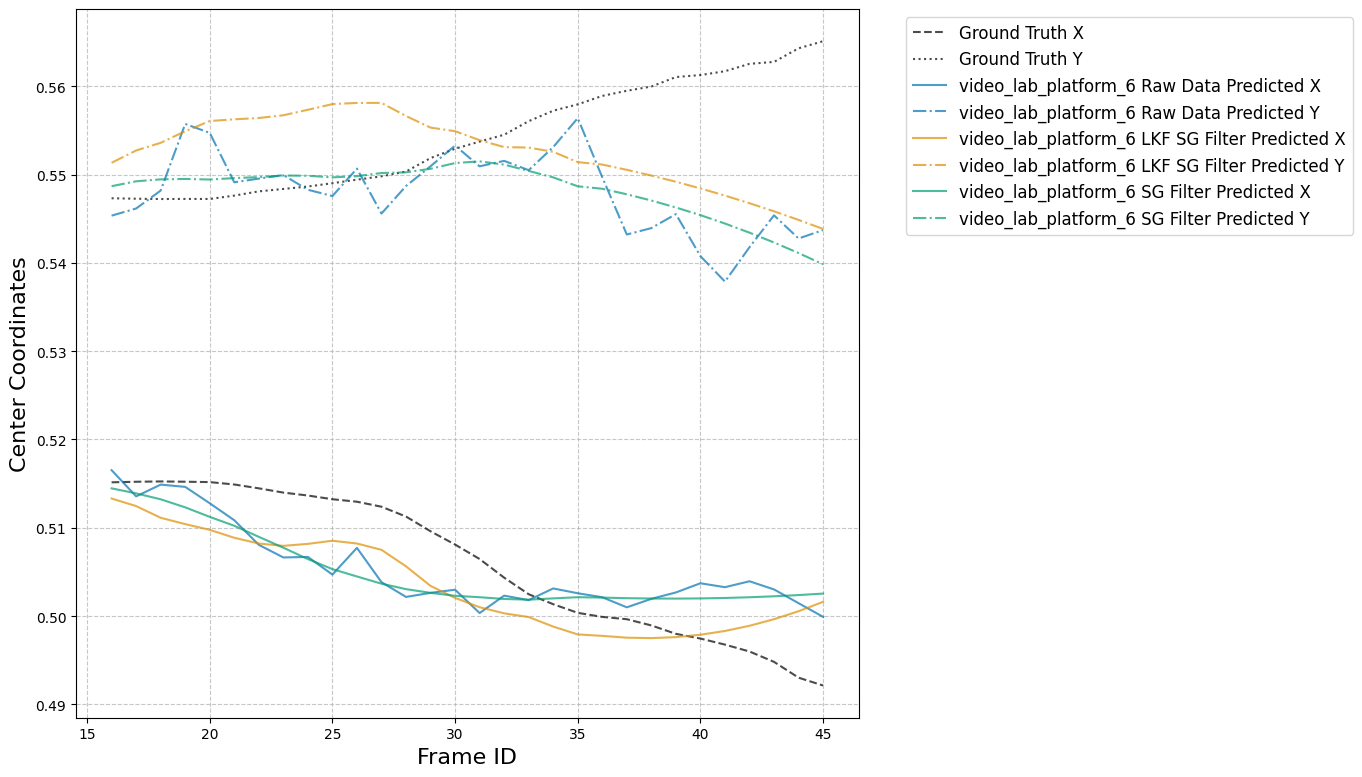

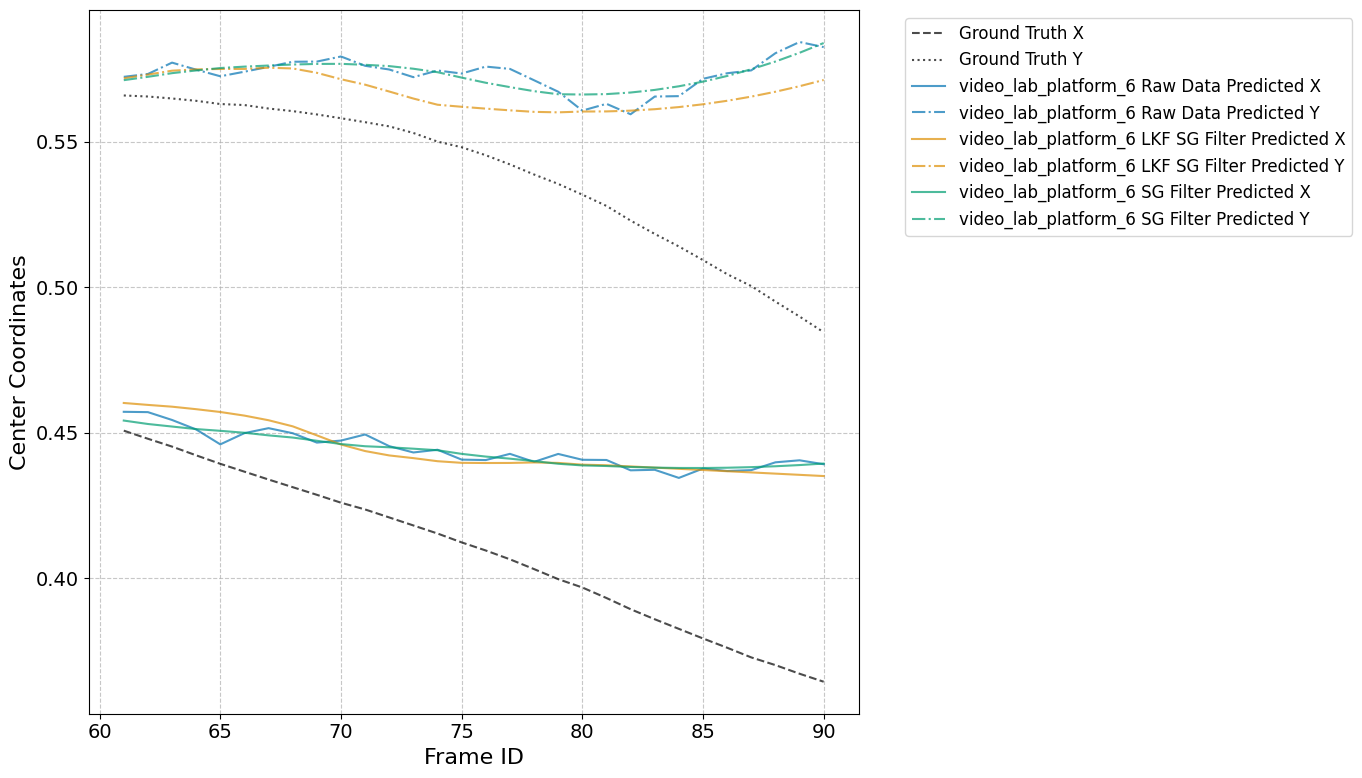

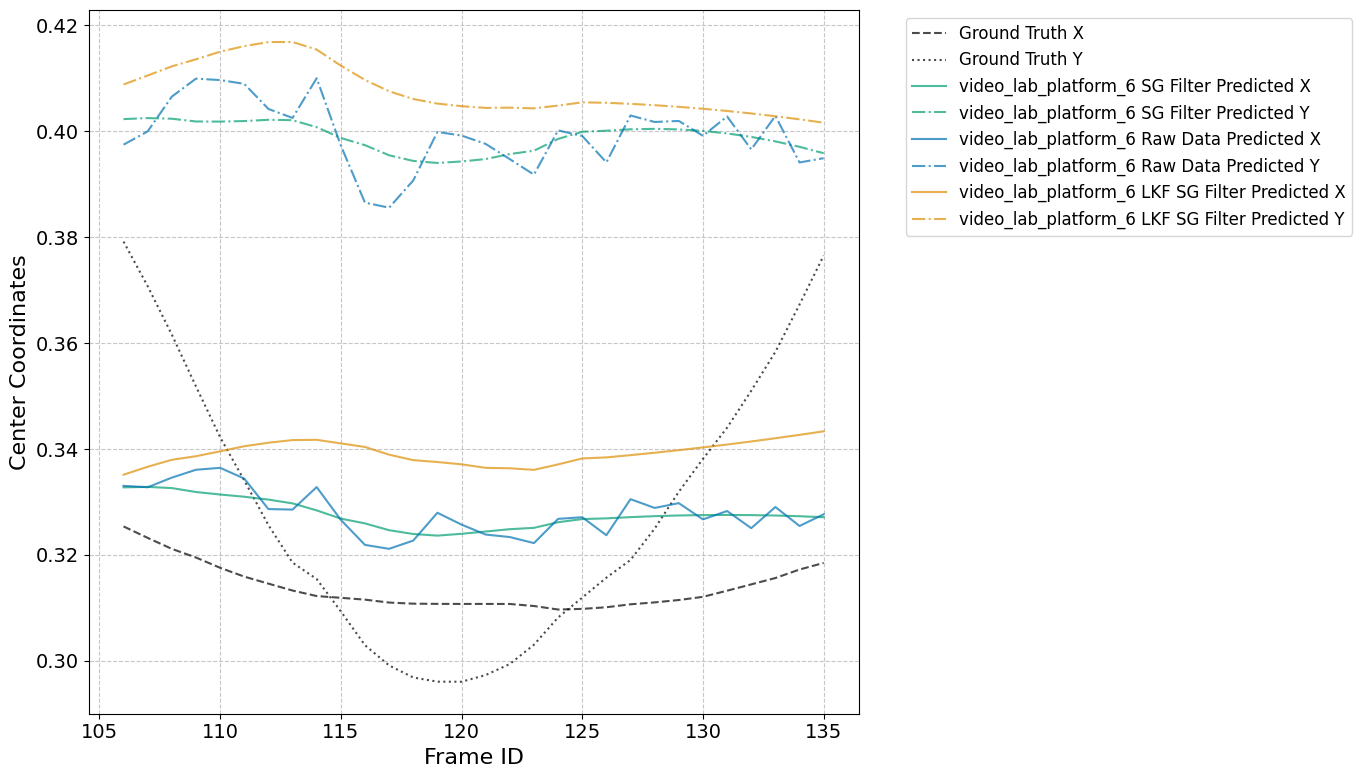

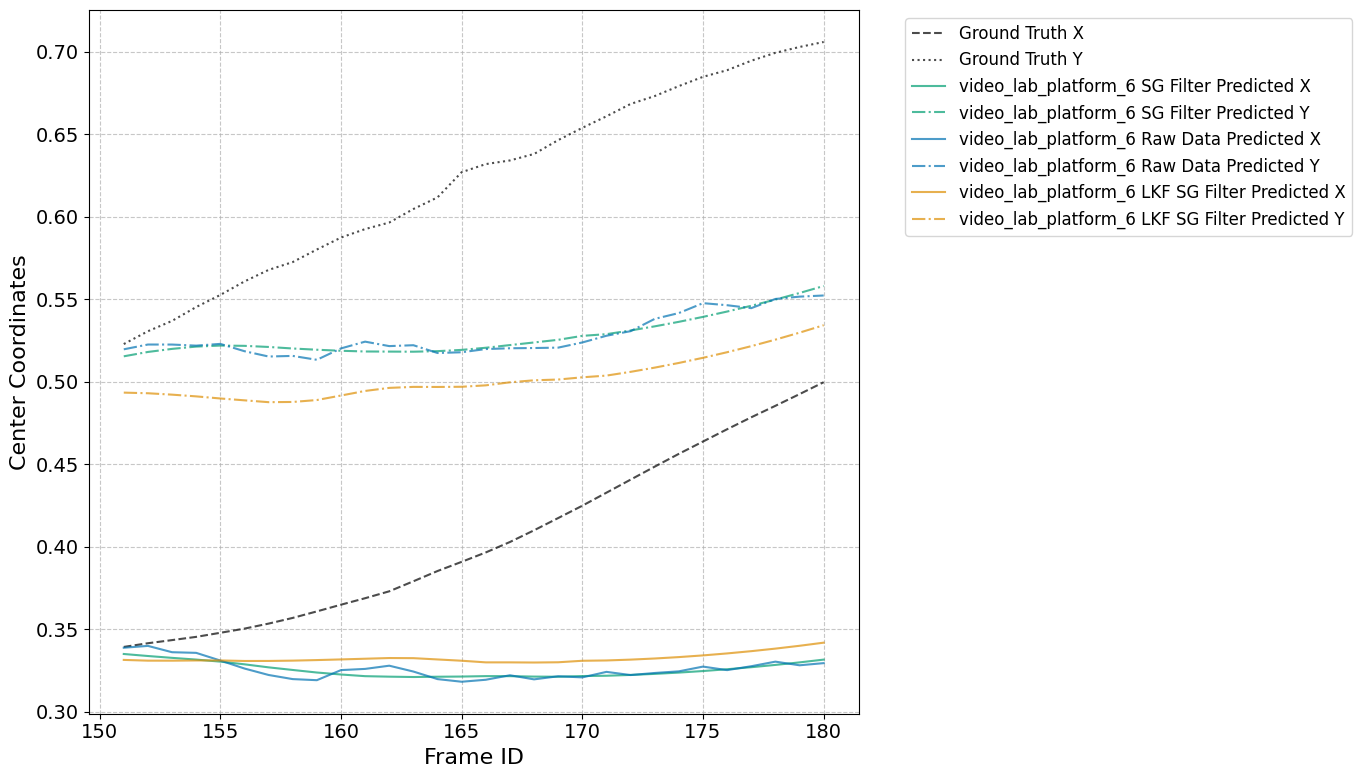

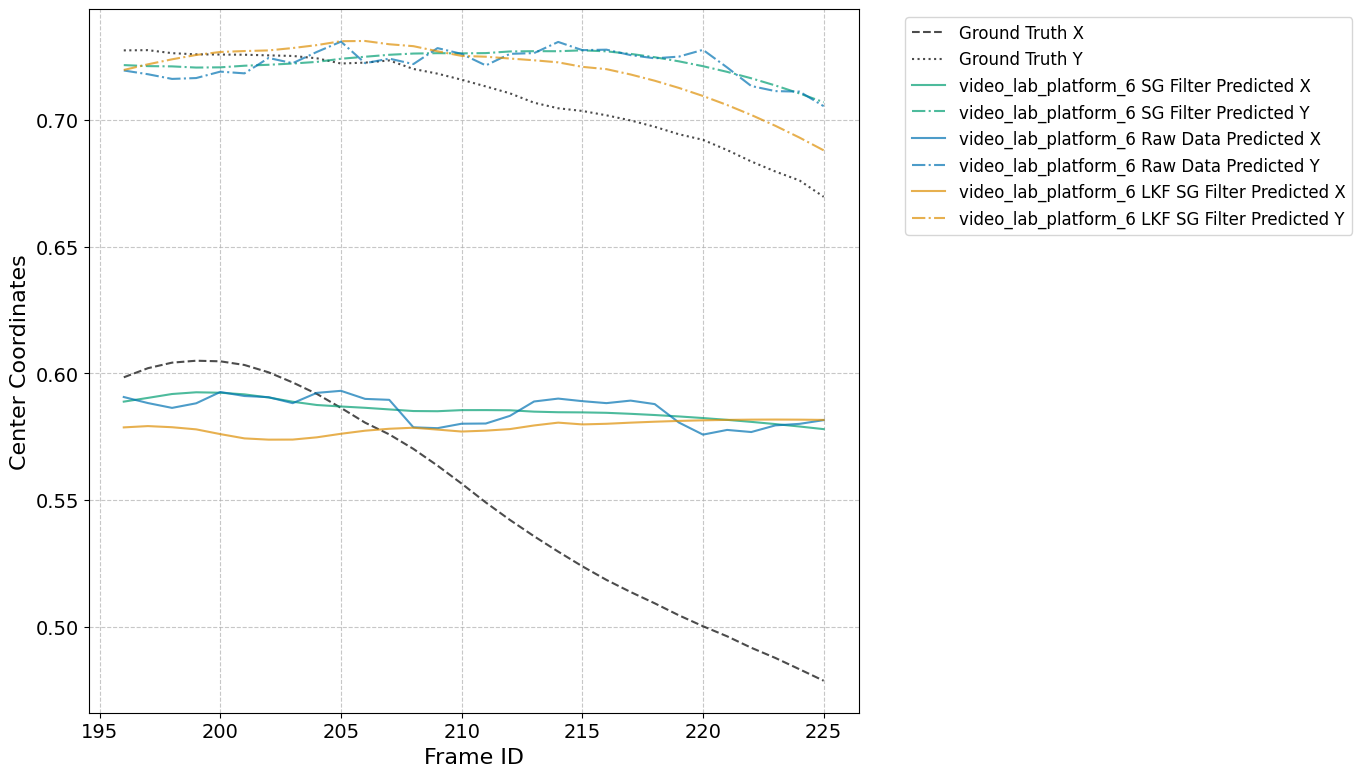

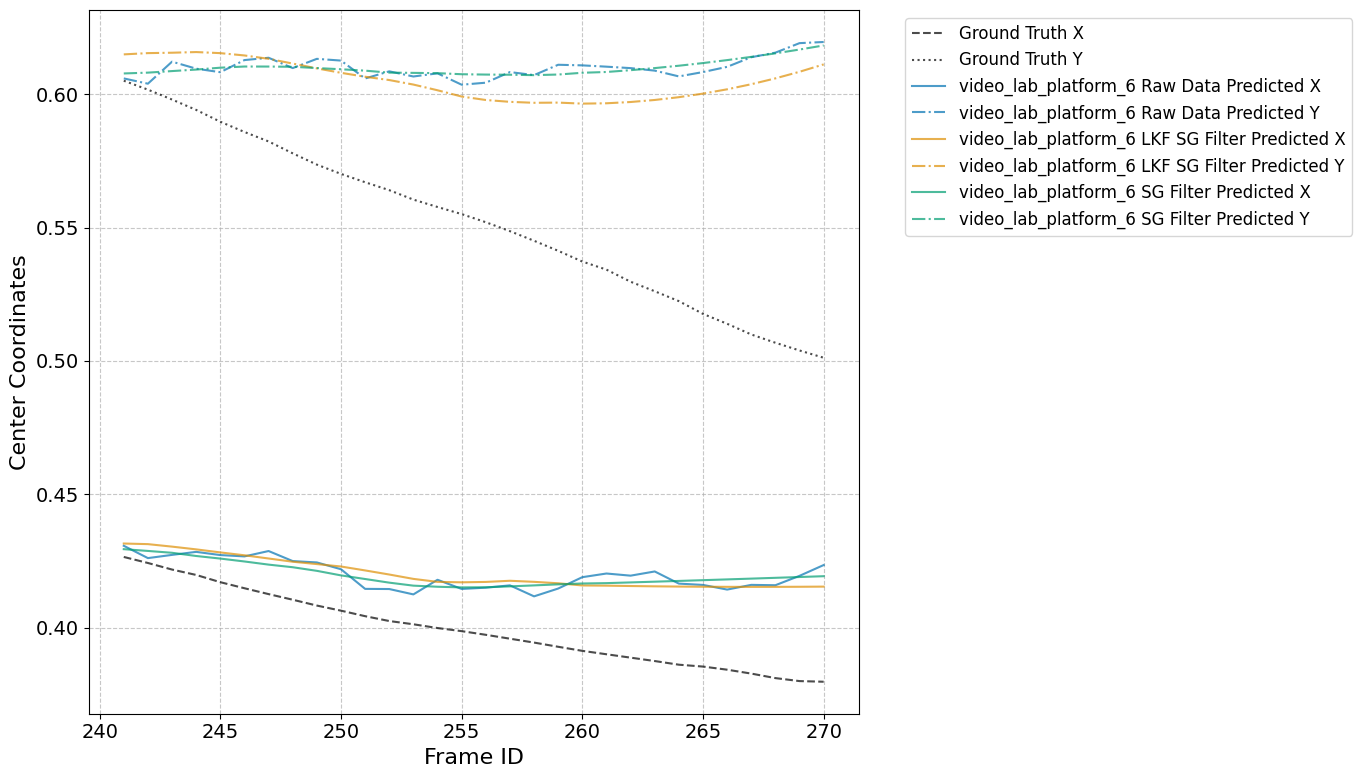

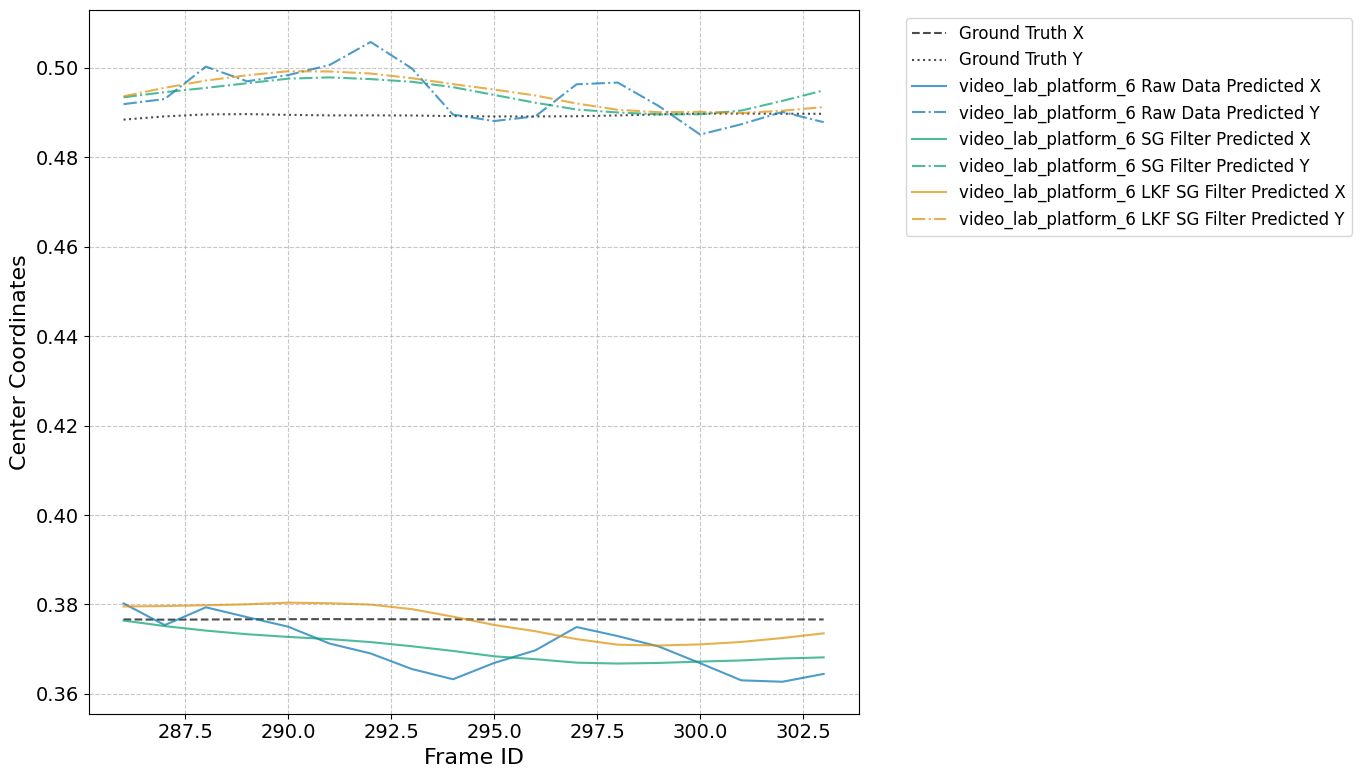

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_trajectory(file_objects, video_name):
    """
    Plots the predicted and ground truth trajectories from multiple JSON files.

    Args:
        file_objects (list): List of dictionaries containing file paths and corresponding names. 
                             Example: [{"file_path": "path/to/file.json", "name": "Model 1"}, ...]
        video_name (str): Name of the video used for saving the plot files.

    Returns:
        None: The function saves the plots as PNG files in the current directory.
    """
    # Set up a color-blind friendly palette
    palette = sns.color_palette("colorblind", n_colors=len(file_objects))
    color_dict = {obj['name']: palette[i] for i, obj in enumerate(file_objects)}

    all_data = []

    # Load and prepare data for each object
    for obj in file_objects:
        file_path = obj['file_path']
        name = obj['name']

        with open(file_path, 'r') as file:
            new_data = json.load(file)

        # Extract relevant data
        for entry in new_data:
            if entry['ground_truth_position'] is not None:
                all_data.append({
                    'name': name,
                    'frame_id': entry['frame_id'],
                    'predicted_x_center': entry['predicted_position']['x_center'],
                    'predicted_y_center': entry['predicted_position']['y_center'],
                    'ground_truth_x_center': entry['ground_truth_position']['x_center'],
                    'ground_truth_y_center': entry['ground_truth_position']['y_center']
                })

    # Convert to DataFrame and sort by frame_id
    df = pd.DataFrame(all_data)
    df = df.sort_values('frame_id')

    # Identify the groups based on the gap of 15 frames
    df['group'] = (df['frame_id'].diff() > 15).cumsum()

    # Plotting separate graphs for each group
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        
        plt.figure(figsize=(14, 8))
        
        # Plot ground truth only once
        ground_truth_data = group_data.iloc[0]  # Assuming ground truth is the same for all methods
        plt.plot(group_data['frame_id'], group_data['ground_truth_x_center'], color='black', linestyle='--', label="Ground Truth X", alpha=0.7)
        plt.plot(group_data['frame_id'], group_data['ground_truth_y_center'], color='black', linestyle=':', label="Ground Truth Y", alpha=0.7)
        
        for name in group_data['name'].unique():
            object_data = group_data[group_data['name'] == name]
            color = color_dict[name]
            
            plt.plot(object_data['frame_id'], object_data['predicted_x_center'], color=color, linestyle='-', label=f"{name} Predicted X", alpha=0.7)
            plt.plot(object_data['frame_id'], object_data['predicted_y_center'], color=color, linestyle='-.', label=f"{name} Predicted Y", alpha=0.7)

        # Styling
        plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})
        plt.rcParams.update({'legend.fontsize': 12})

        plt.xlabel('Frame ID', fontsize=16)
        plt.ylabel('Center Coordinates', fontsize=16)
        # plt.title(f'Trajectory Group {group}', fontsize=18, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)

        # Adjust layout to prevent cut-off labels
        plt.tight_layout()

        # Save and display the figure for the current group
        plt.savefig(f"{video_name}_Group_{group}_Trajectories.png", dpi=300, bbox_inches='tight')
        plt.show()

# Example usage
file_objects = [
    {"file_path": "../../test/predictions__video_lab_platform_6.json", "name": "video_lab_platform_6 Raw Data"},
    {"file_path": "../../test/predictions_lkf_sa_video_lab_platform_6.json", "name": "video_lab_platform_6 LKF SG Filter"},
    {"file_path": "../../test/predictions_sa_video_lab_platform_6.json", "name": "video_lab_platform_6 SG Filter"},
]

plot_trajectory(file_objects, "video_lab_platform_6")